In [185]:
from urllib.request import urlopen
import datetime
from datetime import timedelta
import csv
import pandas as pd
from scipy import signal
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np
import holidays
import pickle
from datetime import timedelta
import math
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import os

In [186]:
#function that constructs model for each set of market sales and produces output file

def model_optimize(market_select,product_select):
   

    #read in the sales/feature files
    
    os.chdir('C:\\Users\\teek2\\Documents\\Revenue_Data_Files')
    revenue_df=pd.read_pickle('Market_revenues.pkl')
    os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Feature_Data_Files')
    feature_df=pd.read_pickle('feature_DataFrame.pkl')
    
    #select the relevant sales data for the desired market
    total_product_revenue=revenue_df[(revenue_df['Market Name']==market_select) & (revenue_df['Market Product']==product_select)]
    #get features for all market dates
    
    feature_predictor_df=total_product_revenue.set_index('Date').join(feature_df.set_index('Market Date'),how='left').reset_index().dropna()
    feature_predictor_df=feature_predictor_df[feature_predictor_df['Revenue']>250]
    continuous_features=cont_feat_dict[market_select+product_select]
    binary_features=bin_feat_dict[market_select+product_select]
    
    y_select='Revenue'

    #test set length
    
    test_length=50

    feature_matrix=feature_predictor_df[continuous_features+binary_features]
    predictor_vector=feature_predictor_df[y_select]

   

    #get training data
    X_train=feature_matrix[:-test_length+1]
    y_train=predictor_vector[:-test_length+1]
    
    #construct scaler to standardize continuous features
    #then scale test and train data
    
    scaler=preprocessing.StandardScaler().fit(X_train[continuous_features])
    X_train_scaled=np.concatenate((scaler.transform(X_train[continuous_features]),np.array(X_train[binary_features])),axis=1)

    X_test=feature_matrix[-test_length:]
    y_test=predictor_vector[-test_length:]

    X_test_scaled=np.concatenate((scaler.transform(X_test[continuous_features]),np.array(X_test[binary_features])),axis=1)
    
    
    #perform gridsearch on train data to find optimal regularization parameters
    param_grid = [
      {'alpha': [.1, 1,5, 10,50, 100, 250, 500,750,1000]}]

    ridge=Ridge()
    ridge_regressor=GridSearchCV(ridge,param_grid,scoring='neg_mean_absolute_error',cv=10)
    ridge_regressor.fit(X_train_scaled,y_train)
    reg_param=ridge_regressor.best_params_['alpha']
    
    #fir ridge regression model with optimized coefficients
    ridge=Ridge(alpha=reg_param)
    ridge.fit(X_train_scaled,y_train)
    
    #output r2 mape/residuals/other model metrics
    ridge_best_score=mean_absolute_error(ridge.predict(X_test_scaled),y_test)
    
    
    best_model_predicts=np.array(ridge.predict(X_test_scaled))
    best_model_residuals=best_model_predicts-np.array(y_test)
    
    best_model_train_residuals=np.array(ridge.predict(X_train_scaled))-np.array(y_train)
    mape_train_model=np.mean(abs(best_model_train_residuals/y_train))
    
    mape_model=np.mean(abs(best_model_residuals/y_test))
    baseline = LinearRegression()
    baseline_features=['Previous Markets','Temperature','Rain']
    
    #output same metrics fro baseline
    baseline.fit(feature_predictor_df[:-test_length+1][baseline_features],y_train)
    X_baseline_test=feature_predictor_df[-test_length:][baseline_features]
    y_baseline_test=y_test
    baseline_predicts=baseline.predict(X_baseline_test)
    baseline_residuals=baseline_predicts-y_test
    mape_baseline=np.mean(abs(baseline_residuals)/y_test)
    mape_naive_baseline=np.mean(abs(np.array(predictor_vector)-np.mean(predictor_vector))/np.array(predictor_vector))
    print("Results for {} Market, {} Vendor".format(market_select,product_select))
    print("Average percent training error for model: {}".format(mape_train_model))
    print("Average percent error for model: {}".format(mape_model))
    print("Baseline avergae percent error: {}".format(mape_baseline))
    print("Naive avergae percent error: {}".format(mape_naive_baseline))
    
    #get a set of scaled features 
    X_scaled=np.concatenate((scaler.transform(feature_matrix[continuous_features]),np.array(feature_matrix[binary_features])),axis=1)
    
    plt.figure()
    plt.plot(feature_predictor_df['Date'],feature_predictor_df['Revenue'],label='Sales')
    plt.plot(feature_predictor_df['Date'],ridge.predict(X_scaled),label='Predictions')
    plt.title("Results for {} Market, {} Vendor".format(market_select,product_select))
    
    #output data
    dataFrameExport=[[binary_features,continuous_features,list(zip(continuous_features+binary_features,ridge.coef_)),feature_predictor_df['Date'],feature_predictor_df['Revenue'],ridge.predict(X_scaled),baseline.predict(feature_predictor_df[baseline_features]),feature_matrix,feature_predictor_df,ridge,baseline,mape_model,mape_baseline]]
    os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Model_Files')
    export_df=pd.DataFrame(dataFrameExport,columns=['binary features','continuous features','model_params','dates','actual sales','model predictions','baseline predictions','feature matrix','dataframe','ridge model','baseline model','ridge mape','baseline mape'])
    pickle.dump(export_df, open(market_select+'_'+product_select+'_AWS.pkl', 'wb'),protocol=2)


    return None


In [187]:
#select features to be used in the different markets/vendors and store in dict

cont_feat_dict={}
bin_feat_dict={}


#PICO HOT FOOD
continuous_features=['Previous Markets','Temperature','Previous Rain','Previous Parking','Wind','Fire Index','Num Vendors','Rain']
bin_features=['FM Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']

cont_feat_dict['PICO'+'Hot Food']=continuous_features
bin_feat_dict['PICO'+'Hot Food']=bin_features

In [188]:
#PICO COFFEE AND BAKED GOODS

continuous_features=['Previous Markets','Previous Parking','Rain','Temperature', 'Wind','FM Index', 'Num Vendors','Time Offset']
bin_features=['Fire Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']

cont_feat_dict['PICO'+'Coffee']=continuous_features
bin_feat_dict['PICO'+'Coffee']=bin_features

continuous_features=[ 'Previous Markets','Rain','Temperature', 'Num Vendors']
bin_features=['Thanksgiving','Christmas', 'July Fourth', 'NYE','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']
                  

cont_feat_dict['PICO'+'Baked Goods']=continuous_features
bin_feat_dict['PICO'+'Baked Goods']=bin_features

In [189]:
#ALL AG FEATURES

continuous_features=['Previous Markets','Previous Parking','Temperature', 'Wind','Fire Index','Num Vendors','Time Offset', 'Rain']
bin_features=['FM Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']


cont_feat_dict['PICO'+'AG']=continuous_features
bin_feat_dict['PICO'+'AG']=bin_features

cont_feat_dict['SUN'+'AG']=continuous_features
bin_feat_dict['SUN'+'AG']=bin_features

cont_feat_dict['SAT'+'AG']=continuous_features
bin_feat_dict['SAT'+'AG']=bin_features

cont_feat_dict['WED'+'AG']=continuous_features
bin_feat_dict['WED'+'AG']=bin_features

In [190]:
#SUNDAY RETAIL
continuous_features=['Previous Markets','Temperature','Previous Parking', 'FM Index','Wind','Num Vendors','Time Offset', 'Rain']
bin_features=['Fire Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']


cont_feat_dict['SUN'+'Retail']=continuous_features
bin_feat_dict['SUN'+'Retail']=bin_features

In [191]:
#SUNDAY PRE-PACKAGED
continuous_features=['Previous Markets','Temperature','Previous Parking','FM Index', 'Wind','Num Vendors','Time Offset', 'Rain']
bin_features=['Fire Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']


cont_feat_dict['SUN'+'Pre-packaged Food']=continuous_features
bin_feat_dict['SUN'+'Pre-packaged Food']=bin_features

In [192]:
#SUNDAY COFFEE

continuous_features=['Previous Markets','Temperature','FM Index','Previous Parking','Previous Rain','Rain']
bin_features=['Fire Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']

cont_feat_dict['SUN'+'Coffee']=continuous_features
bin_feat_dict['SUN'+'Coffee']=bin_features

In [193]:
#SUNDAY BAKED GOODS

continuous_features=['FM Index','Previous Markets', 'Temperature','Num Vendors','Rain']
bin_features=['Fire Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']


cont_feat_dict['SUN'+'Baked Goods']=continuous_features
bin_feat_dict['SUN'+'Baked Goods']=bin_features

In [194]:
#SUNDAY HOT FOODS

continuous_features=['Previous Markets','Temperature','Previous Parking','FM Index', 'Wind','Num Vendors','Time Offset', 'Rain']
bin_features=['Fire Index','Thanksgiving','MLK', 'Labor Day','Wash Day', 'Memorial Day', 'Veterans Day','Christmas', 'July Fourth', 'NYE',\
                  'Superbowls','Is_Jan', 'Is_Feb', 'Is_March',
                  'Is_April', 'Is_May', 'Is_June', 'Is_July', 'Is_August', 'Is_September',
                   'Is_October', 'Is_November', 'Is_December']


cont_feat_dict['SUN'+'Hot Food']=continuous_features
bin_feat_dict['SUN'+'Hot Food']=bin_features

Results for SUN Market, AG Vendor
Average percent training error for model: 0.06766107431421002
Average percent error for model: 0.07807635360094899
Baseline avergae percent error: 0.1076158847140617
Naive avergae percent error: 0.16547568072007376
Results for SUN Market, Coffee Vendor
Average percent training error for model: 0.17389692489908815
Average percent error for model: 0.2930571158484772
Baseline avergae percent error: 0.31412303656602814
Naive avergae percent error: 0.8590801977834578
Results for SUN Market, Baked Goods Vendor
Average percent training error for model: 0.12133601263345799
Average percent error for model: 0.16200067706840757
Baseline avergae percent error: 0.17323012239201
Naive avergae percent error: 0.26419184486818664
Results for SUN Market, Hot Food Vendor
Average percent training error for model: 0.13211685039328191
Average percent error for model: 0.2255176048353476
Baseline avergae percent error: 0.2029947638777089
Naive avergae percent error: 0.2512219

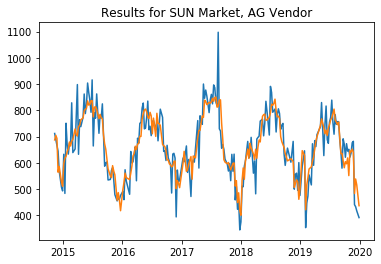

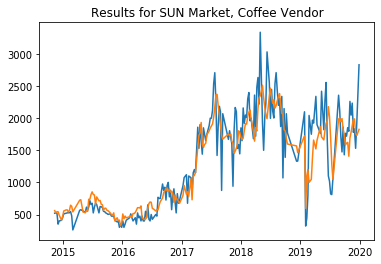

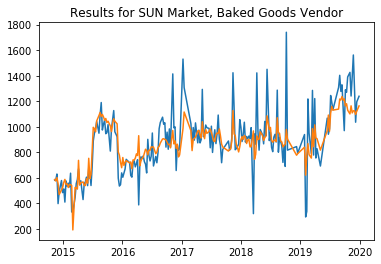

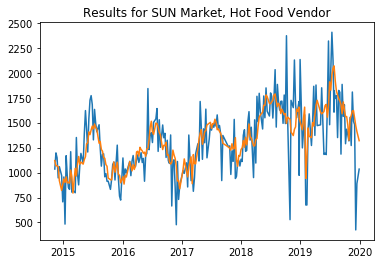

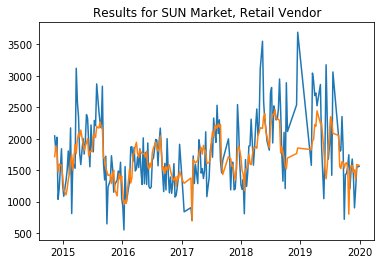

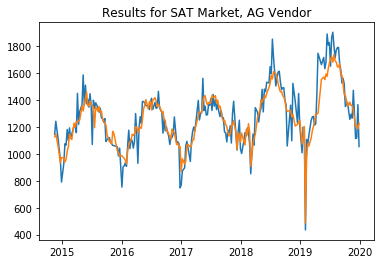

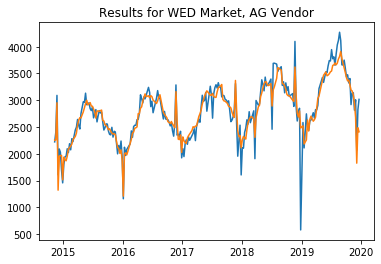

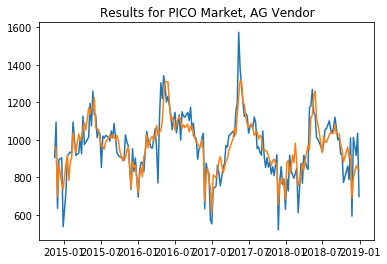

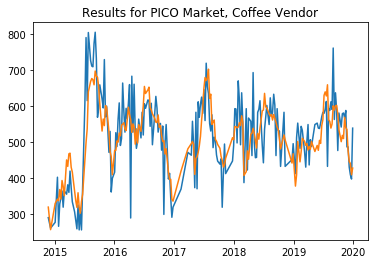

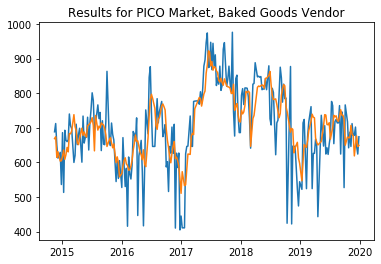

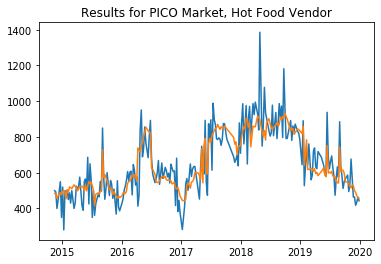

In [195]:
#optimize models for all vendors/markets

markets=['SUN','SAT','WED','PICO']
vendors=[['AG','Coffee','Baked Goods','Hot Food','Retail'],['AG'],['AG'],['AG','Coffee','Baked Goods','Hot Food']]
for i,market in enumerate(markets):
    for vendor in vendors[i]:
        model_optimize(market,vendor)

In [196]:
    os.chdir('C:\\Users\\teek2\\Documents\\Farmers Market Forecast\\Feature_Data_Files')
    feature_df=pd.read_pickle('feature_DataFrame.pkl')